In [ ]:
# Clonamos repo de GitHub completo
!git clone https://github.com/A01795992/NavAut.git

Cloning into 'NavAut'...
remote: Enumerating objects: 27185, done.
remote: Counting objects: 100% (16600/16600), done.
remote: Compressing objects: 100% (16561/16561), done.
remote: Total 27185 (delta 42), reused 16590 (delta 39), pack-reused 10585 (from 3)
Receiving objects: 100% (27185/27185), 395.32 MiB | 18.20 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Updating files: 100% (27084/27084), done.


In [ ]:
# Librerías
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Rutas
# Ruta del dataset
base_path = '/content/NavAut/proyecto_final/dataset_images_V2'

# Ruta del csv
csv_path = '/content/NavAut/proyecto_final/'

# Ruta de imágenes (en este caso, en la misma carpeta base)
images_path = base_path

# Cargar CSV
df = pd.read_csv(csv_path + 'driving_log_V2.csv')

In [ ]:
# Verificacion de Datos

# Verificar número de registros en el CSV
print("Total de registros en CSV:", len(df))

# Verificar número de imágenes en carpeta
imagenes_en_carpeta = [f for f in os.listdir(images_path) if f.endswith('.png')]
print("Imágenes en carpeta:", len(imagenes_en_carpeta))

# Verificar número de archivos totales en carpeta
archivos_en_carpeta = [f for f in os.listdir(images_path)]
print("Archivos totales en carpeta:", len(archivos_en_carpeta))

Total de registros en CSV: 16542
Imágenes en carpeta: 16542
Archivos totales en carpeta: 16542


Imagen 0
Primer path generado: /content/NavAut/proyecto_final/dataset_images_V2/2025-06-21_16-45-40-265421.png
Existe el archivo? True


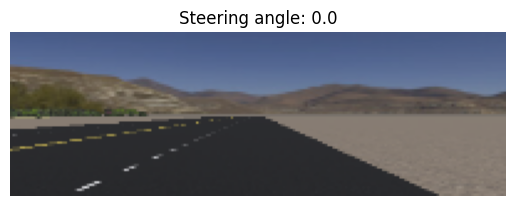

Imagen 1
Primer path generado: /content/NavAut/proyecto_final/dataset_images_V2/2025-06-21_16-45-58-196378.png
Existe el archivo? True


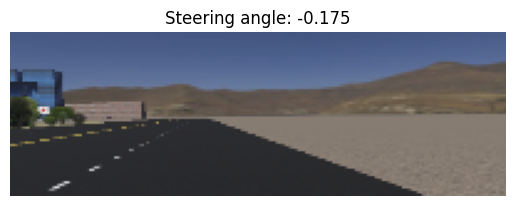

Imagen 2
Primer path generado: /content/NavAut/proyecto_final/dataset_images_V2/2025-06-21_16-46-16-113369.png
Existe el archivo? True


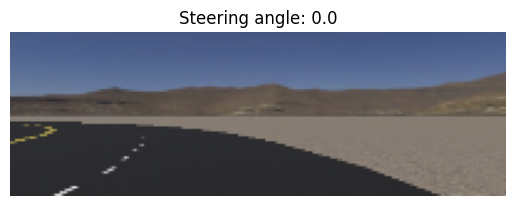

Imagen 3
Primer path generado: /content/NavAut/proyecto_final/dataset_images_V2/2025-06-21_16-46-34-002207.png
Existe el archivo? True


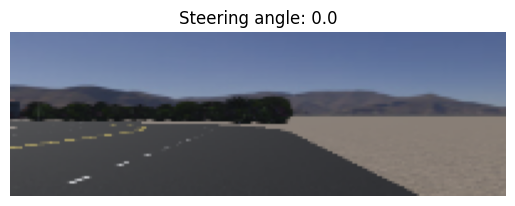

Imagen 4
Primer path generado: /content/NavAut/proyecto_final/dataset_images_V2/2025-06-21_16-46-52-017350.png
Existe el archivo? True


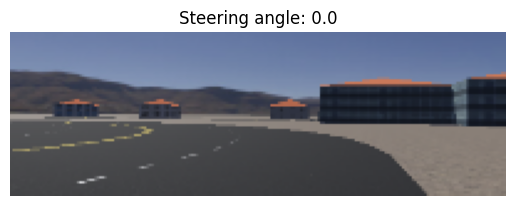

In [ ]:
# Mostrar algunas imagenes con su ángulo de dirección
for i in range(5):
  print(f'Imagen {i}')
  row = df.iloc[i*350]

  img_path = os.path.join(images_path, row['image_name'])
  print("Primer path generado:", img_path)
  print("Existe el archivo?", os.path.exists(img_path))

  img = cv2.imread(img_path)

  if img is None:
      print(f"ERROR: No se pudo leer la imagen {img_path}")
  else:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.title(f"Steering angle: {row['steering_angle']}")
      plt.axis('off')
      plt.show()

In [ ]:
# preprocesamiento de imágenes (normalización)
def preprocess_image(img_path):
    """
    Carga imagen 66x200, la convierte a RGB y normaliza a [-1, 1].
    """
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {img_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img / 127.5 - 1.0

    return img

In [ ]:
row = df.iloc[0]
img_path = os.path.join(images_path, row['image_name'])
img = cv2.imread(img_path)
print("Shape original de la imagen:", img.shape)

Shape original de la imagen: (66, 200, 3)


In [ ]:
#Data Augmentation
import random

def augment_image(img, steering_angle,
                  shift_range=50,  # en pixeles
                  rotation_range=10,  # en grados
                  brightness_range=0.5):  # factor multiplicador

    # 1) Horizontal shift
    tx = shift_range * (np.random.rand() - 0.5)  # desplazamiento aleatorio [-shift_range/2, +shift_range/2]
    ty = 0  # no shift vertical
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # Ajustar steering_angle proporcional al shift
    steering_angle += tx / shift_range * 0.2  # 0.2 = factor de ajuste, puedes tunearlo

    # 2) Rotación
    angle = rotation_range * (np.random.rand() - 0.5)  # rotación aleatoria
    M_rot = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1)
    img = cv2.warpAffine(img, M_rot, (img.shape[1], img.shape[0]))

    # 3) Random brightness
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    brightness_factor = 1.0 + (random.uniform(-brightness_range, brightness_range))
    hsv[:, :, 2] = hsv[:, :, 2] * brightness_factor
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return img, steering_angle

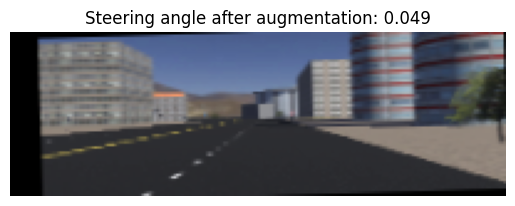

In [ ]:
# Prueba de Data Augmentation

row = df.iloc[1750]  # prueba con cualquier índice
img_path = os.path.join(images_path, row['image_name'])
img = preprocess_image(img_path)

# Des-normalizar para aplicar augmentation (porque preprocess_image devuelve [-1,1])
img_aug = ((img + 1.0) * 127.5).astype(np.uint8)

# Aplicar augmentation
img_aug, angle_aug = augment_image(img_aug, row['steering_angle'])

# Re-normalizar para visualización
img_aug_norm = img_aug.astype(np.float32) / 127.5 - 1.0

# Mostrar
plt.imshow((img_aug_norm + 1.0) / 2.0)
plt.title(f"Steering angle after augmentation: {angle_aug:.3f}")
plt.axis('off')
plt.show()

Original: rectas = 13178 , curvas = 3364
Balanceado: total = 7317
Balanceado: rectas = 3953 , curvas = 3364


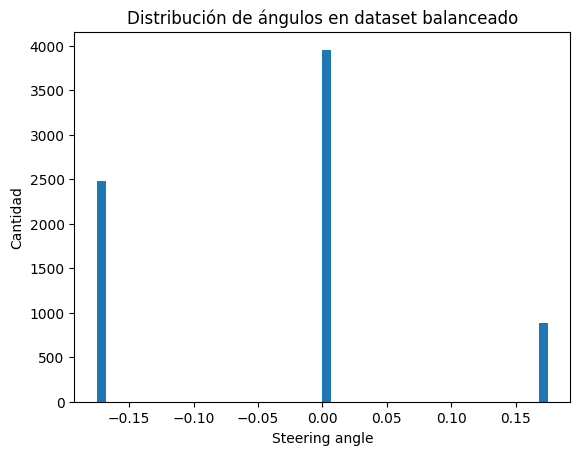

In [ ]:
#
# Crear dataframe balanceado
# - mantendremos todas las curvas
# - usaremos solo un porcentaje de rectas (por ejemplo 30%)

# Definir umbral de "recta" (ángulo cercano a 0)
threshold = 0.05

# Filtrar curvas (ángulo > threshold)
df_curvas = df[abs(df['steering_angle']) > threshold]

# Filtrar rectas (ángulo <= threshold)
df_rectas = df[abs(df['steering_angle']) <= threshold]

# Submuestrear rectas (por ejemplo, 30%)
frac_rectas = 0.3  # ajustable
df_rectas_sample = df_rectas.sample(frac=frac_rectas, random_state=42)

# Combinar curvas + rectas balanceadas
df_balanceado = pd.concat([df_curvas, df_rectas_sample])

# Barajar (shuffle)
df_balanceado = df_balanceado.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Mostrar resultado
print("Original: rectas =", len(df_rectas), ", curvas =", len(df_curvas))
print("Balanceado: total =", len(df_balanceado))
print("Balanceado: rectas =", len(df_rectas_sample), ", curvas =", len(df_curvas))

# Ver distribución de ángulos (opcional)
plt.hist(df_balanceado['steering_angle'], bins=50)
plt.title("Distribución de ángulos en dataset balanceado")
plt.xlabel("Steering angle")
plt.ylabel("Cantidad")
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Lambda
from tensorflow.keras.optimizers import Adam

def nvidia_model():
    model = Sequential()

    # Normalization layer (redundante si ya normalizamos antes, se puede omitir)
    # model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(66, 200, 3)))
    model.add(Lambda(lambda x: x, input_shape=(66, 200, 3)))  # dummy layer para Keras

    # 5 Conv layers (con activación ReLU)
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))

    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))  # previene overfitting

    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='relu'))

    # Output: 1 valor → steering angle
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

    return model

In [ ]:
# Crear el modelo
model = nvidia_model()

# Resumen
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parámetros de entrenamiento
batch_size = 64
epochs = 30

# Directorio para guardar el mejor modelo
output_model_path = 'nvidia_model_best.h5'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(output_model_path, monitor='val_loss', save_best_only=True, verbose=1)
]

# Separar en training / validation
# Por simplicidad, 80% train / 20% validation
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_balanceado, test_size=0.2, random_state=42)

print("Training samples:", len(df_train))
print("Validation samples:", len(df_val))

Training samples: 5853
Validation samples: 1464


In [ ]:
def batch_generator(df_sample, batch_size, is_training):
    """
    Generator que devuelve batches de imágenes + steering_angle.

    - Si is_training = True → aplica augmentation
    - Si is_training = False → solo preprocess
    """
    num_samples = len(df_sample)

    while True:  # loop infinito para fit()
        df_sample = df_sample.sample(frac=1.0)  # shuffle cada epoch

        for offset in range(0, num_samples, batch_size):
            batch_df = df_sample.iloc[offset:offset + batch_size]

            images = []
            angles = []

            for _, row in batch_df.iterrows():
                img_path = os.path.join(images_path, row['image_name'])

                # Cargar imagen y preprocesar
                img = preprocess_image(img_path)

                angle = row['steering_angle']

                if is_training:
                    # Desnormalizar para aplicar augmentation
                    img_aug = ((img + 1.0) * 127.5).astype(np.uint8)
                    img_aug, angle_aug = augment_image(img_aug, angle)
                    # Re-normalizar
                    img_aug = img_aug.astype(np.float32) / 127.5 - 1.0
                    images.append(img_aug)
                    angles.append(angle_aug)
                else:
                    # Solo preprocess
                    images.append(img)
                    angles.append(angle)

            X = np.array(images)
            y = np.array(angles)

            yield X, y

In [ ]:
# Filtrar el dataframe: solo dejar imágenes que existen
df_balanceado['img_exists'] = df_balanceado['image_name'].apply(
    lambda x: os.path.exists(os.path.join(images_path, x))
)

# Mostrar cuántas existen / no existen
print("Total imágenes en CSV:", len(df_balanceado))
print("Imágenes que existen:", df_balanceado['img_exists'].sum())
print("Imágenes que faltan:", len(df_balanceado) - df_balanceado['img_exists'].sum())

# Dejar solo las que existen
df_balanceado = df_balanceado[df_balanceado['img_exists']].reset_index(drop=True)

# Volver a dividir en train/val
df_train, df_val = train_test_split(df_balanceado, test_size=0.2, random_state=42)

print("Training samples:", len(df_train))
print("Validation samples:", len(df_val))

Total imágenes en CSV: 7317
Imágenes que existen: 7317
Imágenes que faltan: 0
Training samples: 5853
Validation samples: 1464


In [ ]:
train_generator = (batch for batch in batch_generator(df_train, batch_size=batch_size, is_training=True))
val_generator = (batch for batch in batch_generator(df_val, batch_size=batch_size, is_training=False))

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(df_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(df_val) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 0.0165
Epoch 1: val_loss improved from inf to 0.00904, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 54s 546ms/step - loss: 0.0165 - val_loss: 0.0090
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - loss: 0.0112
Epoch 2: val_loss improved from 0.00904 to 0.00703, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 81s 896ms/step - loss: 0.0112 - val_loss: 0.0070
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 0.0094
Epoch 3: val_loss improved from 0.00703 to 0.00664, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 907ms/step - loss: 0.0094 - val_loss: 0.0066
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 0.0086
Epoch 4: val_loss improved from 0.00664 to 0.00612, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 901ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.0082
Epoch 5: val_loss improved from 0.00612 to 0.00564, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 905ms/step - loss: 0.0082 - val_loss: 0.0056
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.0081
Epoch 6: val_loss did not improve from 0.00564
91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 907ms/step - loss: 0.0081 - val_loss: 0.0057
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 0.0074
Epoch 7: val_loss improved from 0.00564 to 0.00538, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 903ms/step - loss: 0.0074 - val_loss: 0.0054
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - loss: 0.0073
Epoch 8: val_loss improved from 0.00538 to 0.00507, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 920ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.0069
Epoch 9: val_loss did not improve from 0.00507
91/91 ━━━━━━━━━━━━━━━━━━━━ 47s 518ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 0.0068
Epoch 10: val_loss improved from 0.00507 to 0.00489, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 524ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.0069
Epoch 11: val_loss did not improve from 0.00489
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 524ms/step - loss: 0.0069 - val_loss: 0.0050
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.0064
Epoch 12: val_loss improved from 0.00489 to 0.00484, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 922ms/step - loss: 0.0064 - val_loss: 0.0048
Epoch 13/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 0.0067
Epoch 13: val_loss did not improve from 0.00484
91/91 ━━━━━━━━━━━━━━━━━━━━ 80s 889ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 14/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 0.0063
Epoch 14: val_loss did not improve from 0.00484
91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 917ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 15/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 0.0063
Epoch 15: val_loss improved from 0.00484 to 0.00463, saving model to nvidia_model_best.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 81s 891ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 16/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 0.0062
Epoch 16: val_loss did not improve from 0.00463
91/91 ━━━━━━━━━━━━━━━━━━━━ 46s 511ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 17/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.0062
Epoch 17: val_loss did not improve from 0.00463
91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 912ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 18/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 0.0063
Epoch 18: val_loss did not improve from 0.00463
91/91 ━━━━━━━━━━━━━━━━━━━━ 47s 512ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 19/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 0.0061
Epoch 19: val_loss did not improve from 0.00463
91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 919ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 20/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 0.0062
Epoch 20: val_loss did not improve from 0.00463
91/91 ━━━━━━━━━━━━━━━━━━━━ 81s 892ms/ste

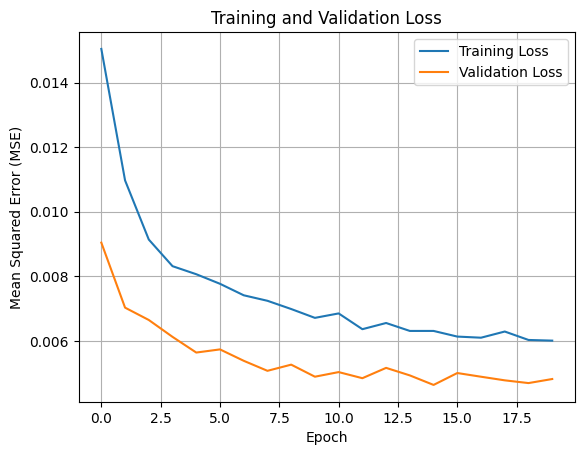

In [ ]:
# Visualización curva de entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid()
plt.show()
